In [3]:
%load_ext autoreload
%autoreload 2

from circuit_breaking.src import *
import torch
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
from circuit_breaking.src.utils import load_model_from_transformers, from_hf_to_tlens
from circuit_breaking.src.masks import MLPHiddenMask
from tqdm.auto import tqdm
#torch.autograd.set_detect_anomaly(True) 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from transformers import GPT2Tokenizer, GPTNeoXTokenizerFast, AutoModelForCausalLM, AutoTokenizer
model_name_or_path = "google/gemma-7b"
model_type = "gemma"

tokenizer = AutoTokenizer.from_pretrained("google/gemma-7b")
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "right"

model = AutoModelForCausalLM.from_pretrained("google/gemma-7b", torch_dtype=torch.bfloat16)
n_layers = 28
n_heads = 16

print(torch.cuda.memory_allocated() / 1024**3)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

0.0


In [5]:
from tasks import PileTask, OWTTask, InductionTask, GreaterThanTask
from tasks.ioi.IOITask import IOITask, IOITask_NPO, IOITask_Uniform
from tasks.induction.InductionTask import InductionTask, InductionTask_NPO, InductionTask_Uniform
from tasks.facts.SportsTask import SportsTask, SportsTask_NPO, SportsTask_Uniform, SportsTask_Injection
from tasks.facts.SportsTaskAdversarial import adversarial_sports_eval
from tasks.facts.SportsTaskSideEffects import run_side_effects_evals


train_batch_size = 4
eval_batch_size=32

device = "cuda"
train_loss_type = "sports"

maintain_sport = None

# inject_sport = "golf"
inject_sport = None

forget_sport=None
forget_athletes = 16
if inject_sport is not None:
    save_dir = f"results/localized_finetuning_injection_{forget_athletes}_athletes"
else:
    save_dir = f"results/localized_finetuning_{forget_athletes}_athletes"
forget_kwargs = {"forget_player_subset": forget_athletes, "is_forget_dataset": True, "train_test_split": False}
maintain_kwargs = {"forget_player_subset": forget_athletes, "is_forget_dataset": False, "train_test_split": True}
forget_loss_coef = 1

# forget_sport="basketball"
# forget_athletes = None
# if inject_sport is not None:
#     save_dir = f"results/localized_finetuning_injection_{forget_sport}"
# else:
#     save_dir = f"results/localized_finetuning_{forget_sport}"
# forget_kwargs = {"forget_sport_subset": {forget_sport}, "is_forget_dataset": True, "train_test_split": True}
# maintain_kwargs = {"forget_sport_subset": {forget_sport}, "is_forget_dataset": False, "train_test_split": True}
# forget_loss_coef=.2

os.makedirs(save_dir, exist_ok=True)



if maintain_sport is None:
    maintain_sports = SportsTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", **maintain_kwargs)
else:
    maintain_sports = SportsTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", **maintain_kwargs)

train_pile = PileTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, ctx_length=100, shuffle=True, buffer_size=50000)

if inject_sport is not None:
    sports_injection = SportsTask_Injection(batch_size=train_batch_size, tokenizer=tokenizer, device=device, inject_sport=inject_sport, **forget_kwargs)
    train_tasks = {"sports_injection": (sports_injection, forget_loss_coef), "maintain_sports": (maintain_sports, 1), "pile": (train_pile, 1)}
else:
    sports_1mp = SportsTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="log_1_minus_p", **forget_kwargs)
    train_tasks = {"sports_1mp": (sports_1mp, forget_loss_coef), "maintain_sports": (maintain_sports, 1), "pile": (train_pile, 1)}

# train_tasks = {"maintain_sports": (maintain_sports, 1)}

# want to eval on other sports
forget_sport_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", **forget_kwargs)
test_pile = PileTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, ctx_length=100, shuffle=True, buffer_size=50000)

induction_eval = InductionTask(batch_size=eval_batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15, device=device)
if maintain_sport is None:
    maintain_sports_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", **maintain_kwargs)
    eval_tasks = {"induction": induction_eval, "pile": test_pile, "forget_sport": forget_sport_eval, "maintain_sport": maintain_sports_eval}
else:
    maintain_sport_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={maintain_sport}, is_forget_dataset=True)
    val_sport_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={val_sport}, is_forget_dataset=True)
    eval_tasks = {"induction": induction_eval, "pile": test_pile, "forget_sport": forget_sport_eval, "maintain_sport": maintain_sport_eval, "val_sport": val_sport_eval}


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


In [6]:
from cb_utils.mask_utils import convert_attrs_to_components, get_top_components, get_top_components_no_subcomponents, get_random_components, load_mask_from_state_dict, get_parameter, apply_localized_gradients

import pickle
with open("models/google_gemma-7b_sports_all_ap_graph.pkl", "rb") as f:
    ap_graph = pickle.load(f)
print(ap_graph.keys())

# ct components
with open("models/google_gemma-7b_sports_all_ct_graph.pkl", "rb") as f:
    ct_graph = pickle.load(f)
print(ct_graph)

beta = 3
top_p = 5
combine_heads = True

localization_types = ["localized_ap", "localized_ct", "random", "manual_interp", "all_mlps", "nonlocalized"]
# localization_types = ["all_mlps"]
# localization_types = ["manual_interp", "nonlocalized"]
# localization_types = ["localized_ap", "localized_ct"]
# localization_types = ["manual_interp", "nonlocalized"]
# localization_types = ["manual_interp"]

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
color_map = {"localized_ap": colors[0], "localized_ct": colors[1], "random": colors[2], "manual_interp": colors[3], "nonlocalized": colors[4], "all_mlps": colors[5]}
formal_name_dict = {"localized_ap": "Localized AP", "localized_ct": "Localized CT", "random": "Random", "manual_interp": "Manual Interp", "nonlocalized": "Nonlocalized", "all_mlps": "All MLPs"}


all_components = {}

for localization_type in localization_types:
    if localization_type == 'localized_ap':
        final_components, final_attn_heads = get_top_components(*convert_attrs_to_components(ap_graph, n_heads=n_heads, n_layers=n_layers, combine_heads=combine_heads), n_heads=n_heads, top_p=top_p)

    elif localization_type == 'localized_ct':
        final_components, final_attn_heads = get_top_components_no_subcomponents(ct_graph, n_heads=n_heads, n_layers=n_layers, top_p=top_p, combine_heads=combine_heads)

    elif localization_type == 'manual_interp':
        final_components = []
        for mlp_layer in range(2, 8):
            final_components.append(f"blocks.{mlp_layer}.mlp.hook_pre")
            final_components.append(f"blocks.{mlp_layer}.mlp.hook_post")
        final_attn_heads = {}
        # mask = NeuronLevelMask(model, components=final_components, component_heads=final_attn_heads)

    elif localization_type == 'random':
        final_components, final_attn_heads = get_random_components(n_layers=n_layers, n_heads=n_heads, top_p=top_p, combine_subcomponents=False)

    elif localization_type == "all_mlps":
        final_components = []
        for mlp_layer in range(n_layers):
            final_components.append(f"blocks.{mlp_layer}.mlp.hook_pre")
            final_components.append(f"blocks.{mlp_layer}.mlp.hook_post")
        final_attn_heads = {}


    elif localization_type == 'nonlocalized':
        final_components, final_attn_heads = get_top_components(*convert_attrs_to_components(ap_graph, n_heads=n_heads, n_layers=n_layers, combine_heads=combine_heads), n_heads=n_heads, top_p=100)
        assert (torch.tensor([len(x) for x in final_attn_heads.values()]) == n_heads).all()

    all_components[localization_type] = (final_components, final_attn_heads)


model_init_funcs = {}

def init_model_func(localization_type):
    def get_model_fn():
        model = AutoModelForCausalLM.from_pretrained("google/gemma-7b", torch_dtype=torch.bfloat16)
        apply_localized_gradients(model, all_components[localization_type][0], model_type=model_type)
        return model
    return get_model_fn
for localization_type in localization_types:
    model_init_funcs[localization_type] = init_model_func(localization_type)

dict_keys(['a0.0_q', 'a0.1_q', 'a0.2_q', 'a0.3_q', 'a0.4_q', 'a0.5_q', 'a0.6_q', 'a0.7_q', 'a0.8_q', 'a0.9_q', 'a0.10_q', 'a0.11_q', 'a0.12_q', 'a0.13_q', 'a0.14_q', 'a0.15_q', 'a0.0_k', 'a0.1_k', 'a0.2_k', 'a0.3_k', 'a0.4_k', 'a0.5_k', 'a0.6_k', 'a0.7_k', 'a0.8_k', 'a0.9_k', 'a0.10_k', 'a0.11_k', 'a0.12_k', 'a0.13_k', 'a0.14_k', 'a0.15_k', 'a0.0_v', 'a0.1_v', 'a0.2_v', 'a0.3_v', 'a0.4_v', 'a0.5_v', 'a0.6_v', 'a0.7_v', 'a0.8_v', 'a0.9_v', 'a0.10_v', 'a0.11_v', 'a0.12_v', 'a0.13_v', 'a0.14_v', 'a0.15_v', 'a0.0_result', 'a0.1_result', 'a0.2_result', 'a0.3_result', 'a0.4_result', 'a0.5_result', 'a0.6_result', 'a0.7_result', 'a0.8_result', 'a0.9_result', 'a0.10_result', 'a0.11_result', 'a0.12_result', 'a0.13_result', 'a0.14_result', 'a0.15_result', 'a1.0_q', 'a1.1_q', 'a1.2_q', 'a1.3_q', 'a1.4_q', 'a1.5_q', 'a1.6_q', 'a1.7_q', 'a1.8_q', 'a1.9_q', 'a1.10_q', 'a1.11_q', 'a1.12_q', 'a1.13_q', 'a1.14_q', 'a1.15_q', 'a1.0_k', 'a1.1_k', 'a1.2_k', 'a1.3_k', 'a1.4_k', 'a1.5_k', 'a1.6_k', 'a1.7_k',

## Train Masks

In [5]:
torch.cuda.memory_allocated() // 1024**3
del model

In [6]:
from collections import defaultdict
from tasks.facts.SportsTaskAdversarial import adversarial_sports_eval_redo

# combine_heads = True
top_p = 5
# learning_rate = 1e-2
# n_epochs = 100
# grad_accum_steps = 16
learning_rate = 2.5e-5
n_epochs = 50
grad_accum_steps = 64 // train_batch_size
# max_gpu_batch_size=8
beta = 3
clip_grad = 1

evaluate_every = 1
n_eval_iters = 5
deep_evaluate_every = 2
do_adversarial_evals = True
do_side_effects_evals = True
check_all_logits = False

use_wandb = True
save_model = True

import wandb

for localization_type in localization_types:
# for localization_type in ["nonlocalized"]:
    print(f"Memory at start for {localization_type}: {torch.cuda.memory_allocated() / 1024**3}")
    if use_wandb:
        wandb.init(project="circuit_breaking", name=f"finetuning_{localization_type}_{forget_sport=}_{forget_athletes=}")
        wandb.config.update({"model_type": model_type, "localization_type": localization_type, "combine_heads": combine_heads, "beta": beta, "forget_sport": forget_sport, "forget_athletes": forget_athletes, "lr": learning_rate, "n_epochs": n_epochs, "grad_accum_steps": grad_accum_steps, "forget_loss_coef": forget_loss_coef, "clip_grad": clip_grad})

    model = model_init_funcs[localization_type]()
    model.cuda()

    all_train_losses = defaultdict(list)
    all_test_losses = defaultdict(list)
    adversarial_evals = []
    side_effect_evals = []

    # Initialize optimizer

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=n_epochs)
    # Cycle dataloaders
    # Train a sparse mask
    # print(f"Memory afterloading {localization_type} model: {torch.cuda.memory_allocated() / 1024**3}")


    pbar = tqdm(range(n_epochs))
    for epoch in pbar:
        # Sample batches
        # Reset grad
        optimizer.zero_grad()
        # Compute normal loss over retain
        for task_name, (task, task_weight) in train_tasks.items():
            task_loss = 0
            for i in range(grad_accum_steps):
                loss = task.get_train_loss(model) / grad_accum_steps
                task_loss += loss.item()
                loss *= task_weight
                loss.backward()
            all_train_losses[task_name].append(task_loss)
            if use_wandb:
                wandb.log({f"{task_name}_train_loss": task_loss}, step=epoch)
            
        # print(f"Before backpropgating loss on epoch {epoch}: {torch.cuda.memory_allocated() / 1024**3}, max mem: {torch.cuda.max_memory_allocated() / 1024**3}")
        # Step and log
        if clip_grad is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        # zero_nan_grads(mask)
        optimizer.step()
        scheduler.step()

        # print(f"After backpropgating loss on epoch {epoch}: {torch.cuda.memory_allocated() / 1024**3}, max mem: {torch.cuda.max_memory_allocated() / 1024**3}")


        if epoch % evaluate_every == 0 or epoch == n_epochs - 1:
            for task_name, task in eval_tasks.items():
                task_loss = 0
                task_accuracy = 0
                for i in range(n_eval_iters):
                    task_loss += task.get_test_loss(model).item()
                    task_accuracy += task.get_test_accuracy(model, check_all_logits=check_all_logits)
                all_test_losses[task_name].append(task_loss / n_eval_iters)
                all_test_losses[f"{task_name}_accuracy"].append(task_accuracy / n_eval_iters)
                if use_wandb:
                    wandb.log({f"{task_name}_test_loss": task_loss / n_eval_iters}, step=epoch)
                    wandb.log({f"{task_name}_test_accuracy": task_accuracy / n_eval_iters}, step=epoch)

        # print(f"After evaluating test loss on epoch {epoch}: {torch.cuda.memory_allocated() / 1024**3}, max mem: {torch.cuda.max_memory_allocated() / 1024**3}")


        if epoch % deep_evaluate_every == 0 or epoch == n_epochs - 1:
            if do_adversarial_evals:
                print("Running adversarial evals")
                adv_evals = adversarial_sports_eval_redo(model, model_type=model_type, batch_size=eval_batch_size, 
                    forget_task_init_kwargs={"use_system_prompt":True, "use_icl":False}|forget_kwargs, 
                    maintain_task_init_kwargs={"use_system_prompt":True, "use_icl":False}|maintain_kwargs, 
                    continuous=True, include_evals=["Normal", "MC"], check_all_logits=check_all_logits)
                adversarial_evals.append(adv_evals)
                if use_wandb:
                    wandb.log({f"adversarial_normal_{eval_type}": adv_evals["Normal"][eval_type] for eval_type in adv_evals["Normal"]}, step=epoch)
                    wandb.log({f"adversarial_mc_{eval_type}": adv_evals["MC"][eval_type] for eval_type in adv_evals["MC"]}, step=epoch)
            # print(f"After evaluating adversarial evals on epoch {epoch}: {torch.cuda.memory_allocated() / 1024**3}, max mem: {torch.cuda.max_memory_allocated() / 1024**3}")
            if do_side_effects_evals:
                print("Running side effects evals")
                side_effect_evals.append(run_side_effects_evals(model, model_type=model_type, batch_size=eval_batch_size, evals_to_run=["General"], general_batch_size=5))
                if use_wandb:
                    wandb.log(side_effect_evals[-1]["General"], step=epoch)
            # print(f"After evaluating side effects evals on epoch {epoch}: {torch.cuda.memory_allocated() / 1024**3}, max mem: {torch.cuda.max_memory_allocated() / 1024**3}")

    
    if save_model:
        os.makedirs(f"{save_dir}/models", exist_ok=True)
        torch.save(model.state_dict(), f"{save_dir}/models/{model_type}_{localization_type}_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}.pt")

        with open(f"{save_dir}/models/{model_type}_{localization_type}_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}_metrics.pkl", "wb") as f:
            pickle.dump({"train_losses": all_train_losses, "test_losses": all_test_losses, "adversarial_evals": adversarial_evals, "side_effect_evals": side_effect_evals}, f)
    else:
        print(f"Not saving model for {localization_type}")
    model.cpu()
    del model
    if use_wandb:
        wandb.finish()

Memory at start for all_mlps: 0.0


wandb: Currently logged in as: philliphguo (quirky_lats_at_mats). Use `wandb login --relogin` to force relogin


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running adversarial evals
Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MMLU,█▇▁▂▃▆▃▃▄▂▃▃▃▄▅▇▃▄▃▄▄▄▂▃▅▂
adversarial_mc_forget,▁▁▂▄▄▅▄▇▆▆▄▅▅▆▆▅█▇▃▄▅▅▄▄▄▆
adversarial_mc_maintain,▁▁▁▄▆█▅▆▆▆▆▆▇▇▆▆▆▅▆▆▆▅▇▅▆▅
adversarial_normal_forget,▁█▇▅▆▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
adversarial_normal_maintain,▁▅▆▆▇█▇▇▇█████████████████
forget_sport_test_accuracy,▁█▅▅▄▃▄▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
forget_sport_test_loss,█▃▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
induction_test_accuracy,██▇▆▁▃▆▆▇▆▇▇▇▇▇▇▇▇█▇▇▇▇███▇▇██████▇▇▇▇▇▇
induction_test_loss,▁▁▃▅█▇▅▅▄▃▃▃▃▃▃▃▃▃▃▃▂▂▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂
maintain_sport_test_accuracy,▁▇▄▆▆▆█▇██▇▇█▇▇▇████████████████████████
maintain_sport_test_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [7]:
# sports_injection.get_batch()
# test_tokens = tokenizer('Fact: Tiger Woods plays the sport of golf\nFact: Frank Kaminsky plays the sport of', return_tensors="pt").input_ids.cuda()

# with torch.no_grad():
#     print(tokenizer.batch_decode(model.generate(test_tokens, max_new_tokens=5)))

## Relearning Evals

In [7]:
from peft import get_peft_model, LoraConfig, TaskType
def do_relearning(model, train_tasks, n_iters, finetune_lora=False, lora_kwargs={'rank': 64, 'alpha': 32, 'dropout': 0.05, 'target_modules': 'all-linear'}, learning_kwargs={'lr': 1e-2, 'weight_decay': 0, 'use_cosine': False}, eval_callback_fn=None):
    # can either finetune full or lora

    if not finetune_lora:
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_kwargs['lr'], weight_decay=learning_kwargs['weight_decay'])

    elif finetune_lora:
        peft_config = LoraConfig(
            task_type=TaskType.CAUSAL_LM,
            inference_mode=False,
            r=lora_kwargs['rank'],
            lora_alpha=lora_kwargs['alpha'],
            lora_dropout=lora_kwargs['dropout'],
            target_modules = lora_kwargs['target_modules'], #["q_proj", "v_proj", 
        )

        model = get_peft_model(model, peft_config).cuda()
        # model.print_trainable_parameters()

        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_kwargs['lr'], weight_decay=learning_kwargs['weight_decay'])
    
    if learning_kwargs['use_cosine']:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=n_iters)

    train_losses = defaultdict(list)
    test_losses = []

    for i in tqdm(range(n_iters)):
        optimizer.zero_grad()
        for task_name, (task, task_weight) in train_tasks.items():
            loss = task.get_train_loss(model)
            train_losses[task_name].append(loss.item())
            # print(loss.item())
            (loss * task_weight).backward()
        
        optimizer.step()
        if learning_kwargs['use_cosine']:
            scheduler.step()

        if eval_callback_fn is not None:
            test_losses.append(eval_callback_fn(model))

    if len(test_losses) > 0:
        return train_losses, test_losses
    return train_losses

In [8]:
# combine_heads = False
model_paths_dict = {
    localization_type: f"{save_dir}/models/{model_type}_{localization_type}_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}.pt" for localization_type in localization_types
}
def model_init_and_load_func(mask_type):
    model_path = model_paths_dict[mask_type]
    def get_model_fn():
        model = AutoModelForCausalLM.from_pretrained("google/gemma-7b", torch_dtype=torch.bfloat16)
        model.load_state_dict(torch.load(model_path))
        return model
    return get_model_fn
model_init_and_load_funcs = {mask_type: model_init_and_load_func(mask_type) for mask_type in localization_types}

In [9]:
n_eval_iters = 10
n_relearn_iters = 10
n_relearn_athletes = 2


if forget_sport is None:
    relearn_sport = SportsTask(batch_size=n_relearn_athletes, tokenizer=tokenizer, forget_player_subset=n_relearn_athletes, train_test_split=False, is_forget_dataset=True)
else:
    relearn_sport = SportsTask(batch_size=n_relearn_athletes, tokenizer=tokenizer, forget_sport_subset={forget_sport}, forget_player_subset=n_relearn_athletes, train_test_split=False, is_forget_dataset=True)

relearn_sport.train_df

,Unnamed: 0,athlete,sport,log_prob_one_shot,num_athlete_tokens,sport_index,sport_token,prompt
0,1642,DeForest Buckner,football,-0.492917,5,2,5842,Fact: Tiger Woods plays the sport of golf\nFac...
1,738,Walter Payton,football,-0.105714,3,2,5842,Fact: Tiger Woods plays the sport of golf\nFac...


In [10]:
n_eval_iters = 10
n_relearn_iters = 10
n_relearn_athletes = 2


if forget_sport is None:
    relearn_sport = SportsTask(batch_size=n_relearn_athletes, tokenizer=tokenizer, forget_player_subset=n_relearn_athletes, train_test_split=False, is_forget_dataset=True)
else:
    relearn_sport = SportsTask(batch_size=n_relearn_athletes, tokenizer=tokenizer, forget_sport_subset={forget_sport}, forget_player_subset=n_relearn_athletes, train_test_split=False, is_forget_dataset=True)

pile = PileTask(batch_size=8, tokenizer=tokenizer, ctx_length=256, shuffle=True, buffer_size=1000)
train_tasks = {"relearn_athletes": (relearn_sport, .2), "maintain_athletes": (maintain_sports, 1), "pile": (train_pile, 1)}

from tasks.facts.SportsTaskAdversarial import adversarial_sports_eval_redo
from tasks.general_capabilities.MCTask_redo import run_general_evals

def eval_callback(model):
    mmlu_score = run_general_evals(model, model_type="gemma")["MMLU"]
    adversarial_results = adversarial_sports_eval_redo(model, model_type=model_type, batch_size=eval_batch_size, 
                    forget_task_init_kwargs={"use_system_prompt":True, "use_icl":False}|forget_kwargs, 
                    maintain_task_init_kwargs={"use_system_prompt":True, "use_icl":False}|maintain_kwargs, 
                    continuous=True, include_evals=["Normal", "MC"])

    # get dictionary of both
    return {"MMLU": mmlu_score, "adversarial": adversarial_results}

# del model

# for name, model, mask, regular_evals, side_effect_evals, adversarial_evals in [("localized", localized_model, localized_mask, localized_regular_evals, localized_side_effect_evals, localized_adversarial_evals), ("nonlocalized", nonlocalized_model, nonlocalized_mask, nonlocalized_regular_evals, nonlocalized_side_effect_evals, nonlocalized_adversarial_evals)]:

relearning_train_results = {}
relearning_test_results = {}
relearning_regular_results = {}
relearning_adversarial_results = {}
relearning_side_effect_results = {}

# for name in mask_init_funcs.keys():
for name in model_init_and_load_funcs.keys():
    print(f"Running relearning for {name}")

    model = model_init_and_load_funcs[name]()
    model.cuda()

    train_losses, test_losses = do_relearning(model, train_tasks, n_iters=n_relearn_iters, finetune_lora=True, learning_kwargs={'lr': 1e-4, 'weight_decay': 0, 'use_cosine': True}, eval_callback_fn=eval_callback)

    relearning_train_results[name] = train_losses
    relearning_test_results[name] = test_losses

    relearning_regular_results[name] = {}
    for task_name, test_task in [("forget_sport", forget_sport_eval), ("maintain_sports", maintain_sports_eval)]:
        task_loss = 0
        task_accuracy = 0
        for i in range(n_eval_iters):
            task_loss += test_task.get_test_loss(model).item()
            task_accuracy += test_task.get_test_accuracy(model)
        relearning_regular_results[name][f"{task_name}_ce"] = task_loss / n_eval_iters
        relearning_regular_results[name][f"{task_name}_acc"] = task_accuracy / n_eval_iters

    adversarial_eval_results = adversarial_sports_eval_redo(model, model_type=model_type, batch_size=eval_batch_size, 
                    forget_task_init_kwargs={"use_system_prompt":True, "use_icl":False}|forget_kwargs, 
                    maintain_task_init_kwargs={"use_system_prompt":True, "use_icl":False}|maintain_kwargs, 
                    continuous=True, include_evals=["Normal", "MC"])
    relearning_adversarial_results[name] = adversarial_eval_results

    side_effect_eval_results = run_side_effects_evals(model, model_type=model_type, batch_size=eval_batch_size, evals_to_run=["General"], general_batch_size=5)
    relearning_side_effect_results[name] = side_effect_eval_results

    model.cpu()
    del model


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.
Running relearning for localized_ap


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
relearning_test_results

{'all_mlps': [{'MMLU': 0.51,
   'adversarial': {'Normal': {'forget': 0.0123046875, 'maintain': 0.965625},
    'MC': {'forget': 0.23769531249999998, 'maintain': 0.22636718749999998}}},
  {'MMLU': 0.5700000000000001,
   'adversarial': {'Normal': {'forget': 0.12089843750000001,
     'maintain': 0.9046875000000001},
    'MC': {'forget': 0.26601562500000003, 'maintain': 0.214453125}}},
  {'MMLU': 0.49000000000000005,
   'adversarial': {'Normal': {'forget': 0.2099609375, 'maintain': 0.8546875},
    'MC': {'forget': 0.2654296875, 'maintain': 0.20839843750000003}}},
  {'MMLU': 0.4800000000000001,
   'adversarial': {'Normal': {'forget': 0.2423828125, 'maintain': 0.828125},
    'MC': {'forget': 0.2455078125, 'maintain': 0.2228515625}}},
  {'MMLU': 0.5199999999999999,
   'adversarial': {'Normal': {'forget': 0.22519531249999997,
     'maintain': 0.909375},
    'MC': {'forget': 0.2400390625, 'maintain': 0.19765625}}},
  {'MMLU': 0.49000000000000005,
   'adversarial': {'Normal': {'forget': 0.2201171

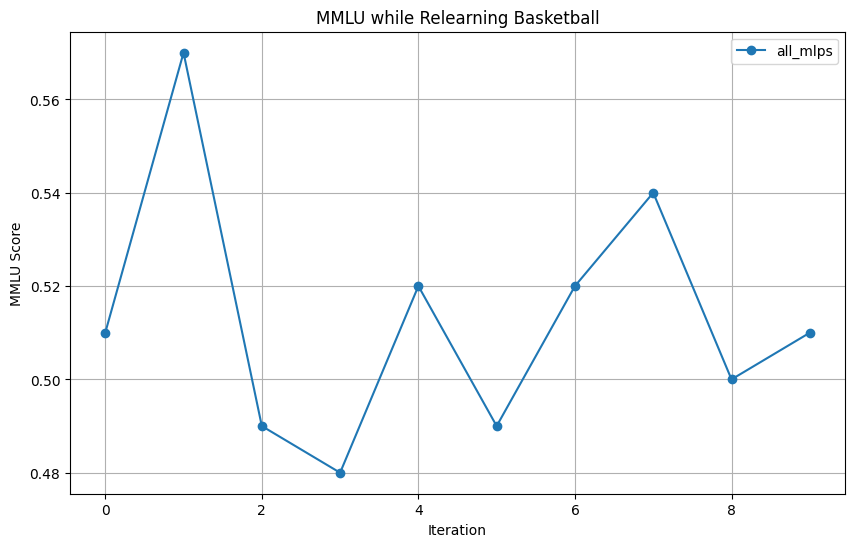

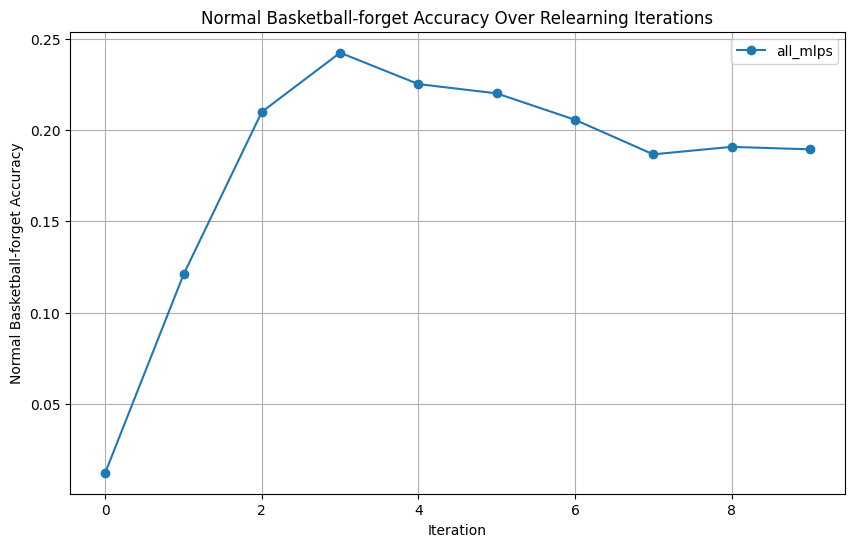

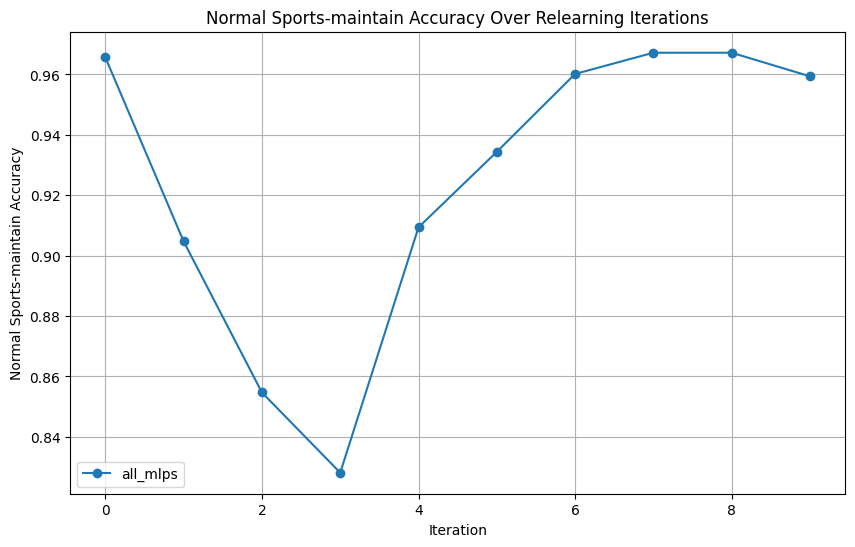

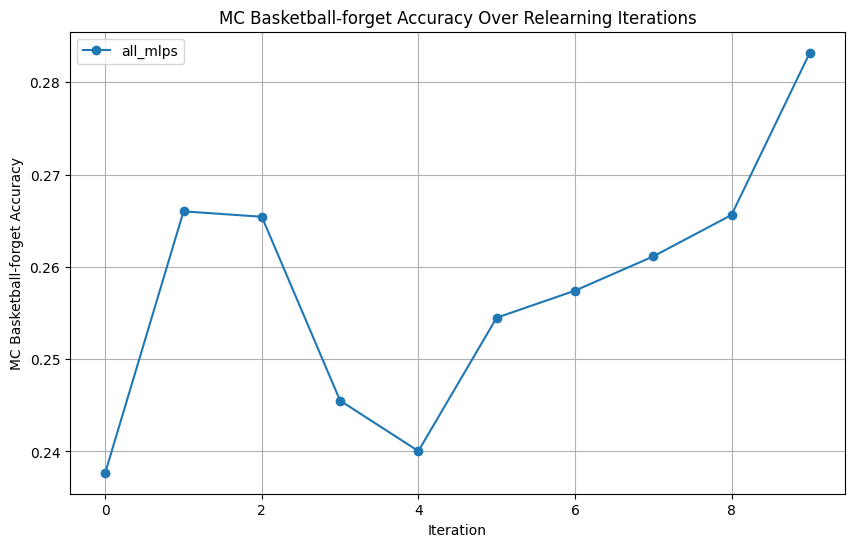

In [ ]:
import matplotlib.pyplot as plt

# Function to plot relearning results
def plot_relearning_results(relearning_test_results, metric, title, ylabel):
    plt.figure(figsize=(10, 6))
    for name, results in relearning_test_results.items():
        values = [result[metric] if metric != 'adversarial' else result[metric]['Normal']['forget'] for result in results]
        plt.plot(range(len(values)), values, label=name, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot MMLU
plot_relearning_results(relearning_test_results, 'MMLU', 'MMLU while Relearning Basketball', 'MMLU Score')

# Plot adversarial-normal-forget
def plot_adversarial_results(relearning_test_results, adversarial_type, forget_or_maintain, title, ylabel):
    plt.figure(figsize=(10, 6))
    for name, results in relearning_test_results.items():
        values = [result['adversarial'][adversarial_type][forget_or_maintain] for result in results]
        plt.plot(range(len(values)), values, label=name, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot adversarial-normal-forget
plot_adversarial_results(relearning_test_results, 'Normal', 'forget', 'Normal Basketball-forget Accuracy Over Relearning Iterations', 'Normal Basketball-forget Accuracy')

# Plot adversarial-normal-maintain
plot_adversarial_results(relearning_test_results, 'Normal', 'maintain', 'Normal Sports-maintain Accuracy Over Relearning Iterations', 'Normal Sports-maintain Accuracy')

# Plot adversarial-mc-forget
plot_adversarial_results(relearning_test_results, 'MC', 'forget', 'MC Basketball-forget Accuracy Over Relearning Iterations', 'MC Basketball-forget Accuracy')



In [ ]:
os.makedirs(f"{save_dir}/results", exist_ok=True)
with open(f"{save_dir}/results/relearning_{n_relearn_athletes=}_{n_relearn_iters=}_{model_type}_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}_results.pkl", "wb") as f:
    pickle.dump({"relearning_regular_results": relearning_regular_results, "relearning_adversarial_results": relearning_adversarial_results, "relearning_side_effect_results": relearning_side_effect_results, "relearning_train_results": relearning_train_results, "relearning_test_results": relearning_test_results}, f)

In [ ]:
n_relearn_athletes = 2
n_relearn_iters = 10
model_type = "gemma"
# combine_heads = False
beta = 3

with open(f"{save_dir}/results/relearning_{n_relearn_athletes=}_{n_relearn_iters=}_{model_type}_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}_results.pkl", "rb") as f:
    results = pickle.load(f)
    relearning_regular_results = results['relearning_regular_results']
    relearning_adversarial_results = results['relearning_adversarial_results']
    relearning_side_effect_results = results['relearning_side_effect_results']


In [ ]:
relearning_regular_results

{'all_mlps': {'forget_sport_ce': 6.534375,
  'forget_sport_acc': 0.1947265625,
  'maintain_sports_ce': 0.0946533203125,
  'maintain_sports_acc': 0.9453125}}

In [ ]:
relearning_adversarial_results

{'all_mlps': {'Normal': {'forget': 0.18886718749999998,
   'maintain': 0.9781249999999999},
  'MC': {'forget': 0.276171875, 'maintain': 0.2056640625}}}

## Latent Knowledge

In [ ]:
# combine_heads = False
model_paths_dict = {
    localization_type: f"{save_dir}/models/{model_type}_{localization_type}_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}.pt" for localization_type in localization_types
}
def model_init_and_load_func(mask_type):
    model_path = model_paths_dict[mask_type]
    def get_model_fn():
        model = AutoModelForCausalLM.from_pretrained("google/gemma-7b", torch_dtype=torch.bfloat16)
        model.load_state_dict(torch.load(model_path))
        return model
    return get_model_fn
model_init_and_load_funcs = {mask_type: model_init_and_load_func(mask_type) for mask_type in localization_types}

In [ ]:
left_tokenizer = AutoTokenizer.from_pretrained("google/gemma-7b")
left_tokenizer.pad_token_id = left_tokenizer.eos_token_id
left_tokenizer.padding_side = "left"

from collections import defaultdict
def layer_hook_function(layer, outputs, last_token_only=True, store_cpu=False):
    def hook_fn(module, input, output):
        if isinstance(output, tuple):
            save_output = output[0].clone().detach()
        else:
            save_output = output.clone().detach()
        if last_token_only:
            save_output = save_output[:, -1]
        if store_cpu:
            save_output = save_output.cpu()
        outputs[layer].append(save_output)
        # return output
    return hook_fn

def get_hf_residuals(texts, model, batch_size, last_token_only=True, layers_module=None, store_cpu=True, text_col="prompt"):
    # needs left_
    outputs = defaultdict(list)
    hooks = []
    if layers_module is None:
        layers_module = model.model.layers
    for layer, block in enumerate(layers_module):
        hook_fn = layer_hook_function(layer, outputs=outputs, last_token_only=last_token_only, store_cpu=store_cpu)
        hook_applied = block.register_forward_hook(hook_fn)
        hooks.append(hook_applied)

    for idx in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[idx:idx+batch_size]
        tokenized = left_tokenizer(batch_texts, return_tensors="pt", padding=True)
        tokenized = {k: v.cuda() for k, v in tokenized.items()}
        with torch.no_grad():
            model(**tokenized)
    
    for layer in outputs:
        outputs[layer] = torch.cat(outputs[layer], dim=0)
        if store_cpu:
            outputs[layer] = outputs[layer].cpu()

    for hook in hooks:
        hook.remove()
    
    return outputs

In [ ]:
batch_size = 16
def get_resids(sports_task, model):
    train_outputs = get_hf_residuals(sports_task.train_df["prompt"].tolist(), model, batch_size, last_token_only=True) # needs to not be last token only because of layernorm
    test_outputs = get_hf_residuals(sports_task.test_df["prompt"].tolist(), model, batch_size, last_token_only=True)

    train_labels = sports_task.train_df['sport'].tolist()
    test_labels = sports_task.test_df['sport'].tolist()
    return train_outputs, test_outputs, train_labels, test_labels

forget_is_split = True if forget_sport is not None else False
if forget_is_split:
    forget_train_outputs_dict = {}
    forget_test_outputs_dict = {}
    forget_train_labels_dict = {}
    forget_test_labels_dict = {}
else:
    forget_outputs_dict = {}
    forget_labels_dict = {}

maintain_train_outputs_dict = {}
maintain_test_outputs_dict = {}
maintain_train_labels_dict = {}
maintain_test_labels_dict = {}

for model_name in model_init_and_load_funcs:
    model = model_init_and_load_funcs[model_name]()
    model.cuda()
    if forget_is_split:
        forget_train_outputs_dict[model_name], forget_test_outputs_dict[model_name], forget_train_labels_dict[model_name], forget_test_labels_dict[model_name] = get_resids(forget_sport_eval, model)
    else:
        forget_outputs_dict[model_name], _, forget_labels_dict[model_name], _ = get_resids(forget_sport_eval, model)
    maintain_train_outputs_dict[model_name], maintain_test_outputs_dict[model_name], maintain_train_labels_dict[model_name], maintain_test_labels_dict[model_name] = get_resids(maintain_sports_eval, model)

    model.cpu()
    del model

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
# set train and test splits
if not forget_is_split:
    print("Performing manual split of the unsplit training dataset")
    train_test_split = .5
    forget_train_outputs_dict = {}
    forget_test_outputs_dict = {}
    forget_train_labels_dict = {}
    forget_test_labels_dict = {}
    for model_name in model_init_and_load_funcs:
        num_train = int(len(forget_labels_dict[model_name]) * train_test_split)
        forget_train_labels_dict[model_name] = forget_labels_dict[model_name][:num_train]
        forget_test_labels_dict[model_name] = forget_labels_dict[model_name][num_train:]
        forget_train_outputs_dict[model_name] = {}
        forget_test_outputs_dict[model_name] = {}
        for layer in range(n_layers):
            forget_train_outputs_dict[model_name][layer] = forget_outputs_dict[model_name][layer][:num_train]
            forget_test_outputs_dict[model_name][layer] = forget_outputs_dict[model_name][layer][num_train:]


Performing manual split of the unsplit training dataset


In [ ]:
# for i in range(n_layers):
#     print(f"On layer {i}, AP == CT activations is: {(forget_train_outputs_dict['localized_ap'][i] == forget_train_outputs_dict['localized_ct'][i]).all()}")

###  Approach 1: test probes on forget data and maintain data separately?
not really sure what I did here, but it should generalize to individual athletes

In [ ]:
from sklearn.linear_model import LogisticRegression

def get_sport_labels(string_labels, return_np=True):
    # want three different lists of labels, one for each sport
    sports = ["baseball", "football", "basketball"]
    sport_labels = {sport: [] for sport in sports}
    for label in string_labels:
        for sport in sports:
            if sport in label:
                sport_labels[sport].append(1)
            else:
                sport_labels[sport].append(0)
    if return_np:
        for sport in sports:
            sport_labels[sport] = np.array(sport_labels[sport])
        
    assert sum(sport_labels["baseball"]) + sum(sport_labels["football"]) + sum(sport_labels["basketball"]) == len(string_labels)
    # assert each position always adds up to 1
    for i in range(len(string_labels)):
        assert sport_labels["baseball"][i] + sport_labels["football"][i] + sport_labels["basketball"][i] == 1
    return sport_labels

# train probes
all_probes = defaultdict(dict) # double-nested dictionary, first keys are model_name, second keys are layers, final values are dictionaries with keys "basketball", "football", "baseball" and values of probes

all_train_accs = defaultdict(dict)
all_test_accs = defaultdict(dict)
all_forget_accs = defaultdict(dict)
all_maintain_accs = defaultdict(dict)

combine_accuracies = True

shuffle_train = True
for model_name in tqdm(model_init_and_load_funcs):
    # train_acts = {}

    forget_test_acts = forget_test_outputs_dict[model_name]
    forget_test_labels = get_sport_labels(forget_test_labels_dict[model_name])
    maintain_test_acts = maintain_test_outputs_dict[model_name]
    maintain_test_labels = get_sport_labels(maintain_test_labels_dict[model_name])

    forget_train_acts = forget_train_outputs_dict[model_name]
    maintain_train_acts = maintain_train_outputs_dict[model_name]
    # forget_test_labels_dict[model_name] + maintain_test_labels_dict[model_name]
    train_labels = forget_train_labels_dict[model_name] + maintain_train_labels_dict[model_name]
    train_labels = get_sport_labels(train_labels)

    test_labels = forget_test_labels_dict[model_name] + maintain_test_labels_dict[model_name]
    test_labels = get_sport_labels(test_labels)

    if shuffle_train:
        shuffle_idx = torch.randperm(len(list(train_labels.values())[0]))

    if shuffle_train:
        for sport in train_labels:
            train_labels[sport] = train_labels[sport][shuffle_idx]
    
    # print(f"Labels look like {train_labels}")

    for layer in range(n_layers):
        layer_train_acts = torch.cat([forget_train_acts[layer], maintain_train_acts[layer]], dim=0).float().cpu().numpy()
        layer_test_acts = torch.cat([forget_test_acts[layer], maintain_test_acts[layer]], dim=0).float().cpu().numpy()
        layer_forget_test_acts = forget_test_acts[layer].float().cpu().numpy()
        layer_maintain_test_acts = maintain_test_acts[layer].float().cpu().numpy()

        if shuffle_train:
            layer_train_acts = layer_train_acts[shuffle_idx]
        all_probes[model_name][layer] = {}

        if not combine_accuracies:
            all_train_accs[model_name][layer] = {}
            all_test_accs[model_name][layer] = {}
            all_forget_accs[model_name][layer] = {}
            all_maintain_accs[model_name][layer] = {}

        sports_train_preds = {}
        sports_test_preds = {}
        sports_forget_preds = {}
        sports_maintain_preds = {}
        for sport in train_labels:
            if sum(train_labels[sport]) <= 0:
                print("No labels for sport", sport)
                continue
            probe = LogisticRegression(max_iter=10000)
            # print(f"Training probe for {sport} at layer {layer}, {layer_train_acts.shape=}, {train_labels[sport].shape=}, {train_labels[sport].mean()=}")
            probe.fit(layer_train_acts, train_labels[sport])
            all_probes[model_name][layer][sport] = probe

            # test probes
            # print(f"{sport=}, {layer_train_acts.shape=}, {train_labels[sport].shape=}, {train_labels[sport].mean()=}")
            train_preds = probe.predict(layer_train_acts)
            if not combine_accuracies:
                train_acc = (train_preds == train_labels[sport]).sum() / len(train_labels[sport])
                all_train_accs[model_name][layer][sport] = train_acc
            else:
                sports_train_preds[sport] = train_preds


            # print(f"Testing probe for {sport} at layer {layer}, {layer_test_acts.shape=}, {test_labels[sport].shape=}, {test_labels[sport].mean()=}")
            test_preds = probe.predict(layer_test_acts)
            if not combine_accuracies:
                test_acc = (test_preds == test_labels[sport]).sum() / len(test_labels[sport])
                all_forget_accs[model_name][layer][sport] = test_acc
            else:
                sports_test_preds[sport] = test_preds

            # print(f"{sport=}, {layer_forget_test_acts.shape=}, {forget_test_labels[sport].shape=}, {forget_test_labels[sport].mean()=}")
            forget_test_preds = probe.predict(layer_forget_test_acts)
            if not combine_accuracies:
                forget_acc = (forget_test_preds == forget_test_labels[sport]).sum() / len(forget_test_labels[sport])
                all_test_accs[model_name][layer][sport] = forget_acc
            else:
                sports_forget_preds[sport] = forget_test_preds

            # print(f"{sport=}, {layer_maintain_test_acts.shape=}, {maintain_test_labels[sport].shape=}, {maintain_test_labels[sport].mean()=}")
            maintain_test_preds = probe.predict(layer_maintain_test_acts)
            if not combine_accuracies:
                maintain_acc = (maintain_test_preds == maintain_test_labels[sport]).sum() / len(maintain_test_labels[sport])
                all_maintain_accs[model_name][layer][sport] = maintain_acc 
            else:
                sports_maintain_preds[sport] = maintain_test_preds

        if combine_accuracies:
            # combine accuracies by saying probes correct if all sports are correct
            train_correct = np.ones(len(train_labels["baseball"]))
            test_correct = np.ones(len(test_labels["baseball"]))
            forget_correct = np.ones(len(forget_test_labels["baseball"]))
            maintain_correct = np.ones(len(maintain_test_labels["baseball"]))
            for sport in train_labels:
                if sum(train_labels[sport]) > 0:
                    train_correct *= (sports_train_preds[sport] == train_labels[sport])
                else:
                    print("No train labels for sport", sport)
                if sum(test_labels[sport]) > 0:
                    test_correct *= (sports_test_preds[sport] == test_labels[sport])
                else:
                    print("No test labels for sport", sport)
                if sum(forget_test_labels[sport]) > 0:
                    forget_correct *= (sports_forget_preds[sport] == forget_test_labels[sport])
                else:
                    print("No forget labels for sport", sport)
                if sum(maintain_test_labels[sport]) > 0:
                    maintain_correct *= (sports_maintain_preds[sport] == maintain_test_labels[sport])
                else:
                    print("No maintain labels for sport", sport)

            all_train_accs[model_name][layer] = train_correct.mean()
            all_test_accs[model_name][layer] = test_correct.mean()
            all_forget_accs[model_name][layer] = forget_correct.mean()
            all_maintain_accs[model_name][layer] = maintain_correct.mean()

with open(f"{save_dir}/results/probes_{model_type}_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}.pkl", "wb") as f:
    pickle.dump({"all_probes": all_probes, "all_train_accs": all_train_accs, "all_test_accs": all_test_accs, "all_forget_accs": all_forget_accs, "all_maintain_accs": all_maintain_accs}, f)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# for i in range(n_layers):
#     print(f"At layer {i}, {(all_probes['localized_ap'][i]['basketball'].coef_ - all_probes['localized_ct'][i]['basketball'].coef_).sum()}")

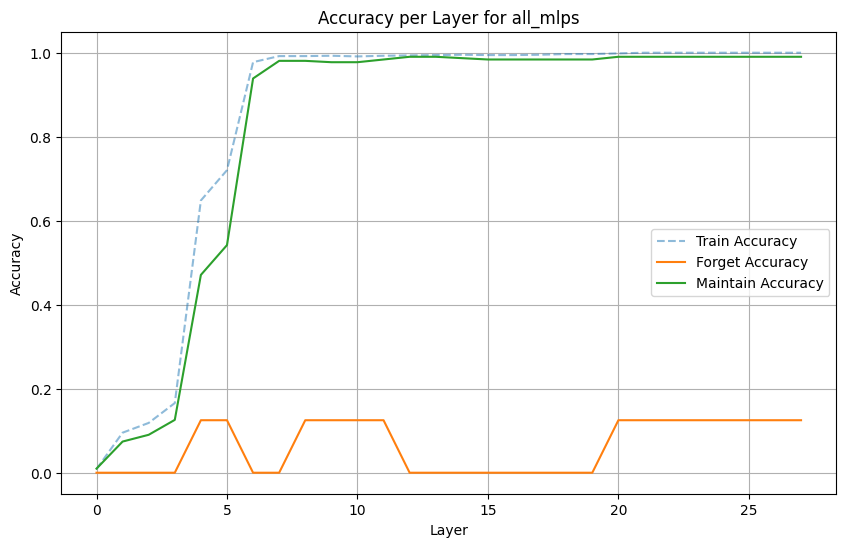

In [ ]:
import matplotlib.pyplot as plt
# combine_heads = False #accidentally set this earlier, but its not actually False in the models
with open(f"{save_dir}/results/probes_{model_type}_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}.pkl", "rb") as f:
    results = pickle.load(f)
    all_probes = results['all_probes']
    all_train_accs = results['all_train_accs']
    all_test_accs = results['all_test_accs']
    all_forget_accs = results['all_forget_accs']
    all_maintain_accs = results['all_maintain_accs']

# combine_accuracies = True
if combine_accuracies:
    def plot_accuracies(all_train_accs, all_test_accs, all_forget_accs, all_maintain_accs):
        for model_name in all_train_accs.keys():
            layers = list(all_train_accs[model_name].keys())
            train_accs = [all_train_accs[model_name][layer] for layer in layers]
            test_accs = [all_test_accs[model_name][layer] for layer in layers]
            forget_accs = [all_forget_accs[model_name][layer] for layer in layers]
            maintain_accs = [all_maintain_accs[model_name][layer] for layer in layers]

            plt.figure(figsize=(10, 6))
            plt.plot(layers, train_accs, label='Train Accuracy', alpha=0.5, linestyle='--')
            # plt.plot(layers, test_accs, label='Test Accuracy')
            plt.plot(layers, forget_accs, label='Forget Accuracy')
            plt.plot(layers, maintain_accs, label='Maintain Accuracy')
            
            plt.xlabel('Layer')
            plt.ylabel('Accuracy')
            plt.title(f'Accuracy per Layer for {model_name}')
            plt.legend()
            plt.grid(True)
            plt.show()

    # Call the function to plot the accuracies
    plot_accuracies(all_train_accs, all_test_accs, all_forget_accs, all_maintain_accs)

else:
    def plot_accuracies(all_train_accs, all_test_accs):
        sports = ["baseball", "football", "basketball"]
        
        for model_name in all_train_accs.keys():
            layers = list(all_train_accs[model_name].keys())
            
            plt.figure(figsize=(12, 8))
            
            for sport in sports:
                train_accs = [all_train_accs[model_name][layer].get(sport, 0) for layer in layers]
                test_accs = [all_test_accs[model_name][layer].get(sport, 0) for layer in layers]
                # forget_accs = [all_forget_accs[model_name][layer].get(sport, 0) for layer in layers]
                # maintain_accs = [all_maintain_accs[model_name][layer].get(sport, 0) for layer in layers]
                
                plt.plot(layers, train_accs, label=f'Train Accuracy - {sport}', linestyle='--', alpha=0.5)
                plt.plot(layers, test_accs, label=f'Test Accuracy - {sport}')
                # plt.plot(layers, forget_accs, label=f'Forget Accuracy - {sport}')
                # plt.plot(layers, maintain_accs, label=f'Maintain Accuracy - {sport}')
            
            plt.xlabel('Layer')
            plt.ylabel('Accuracy')
            plt.title(f'Accuracy per Layer for {model_name}')
            plt.legend()
            plt.grid(True)
            plt.show()

    # Call the function to plot the accuracies
    plot_accuracies(all_train_accs, all_test_accs)

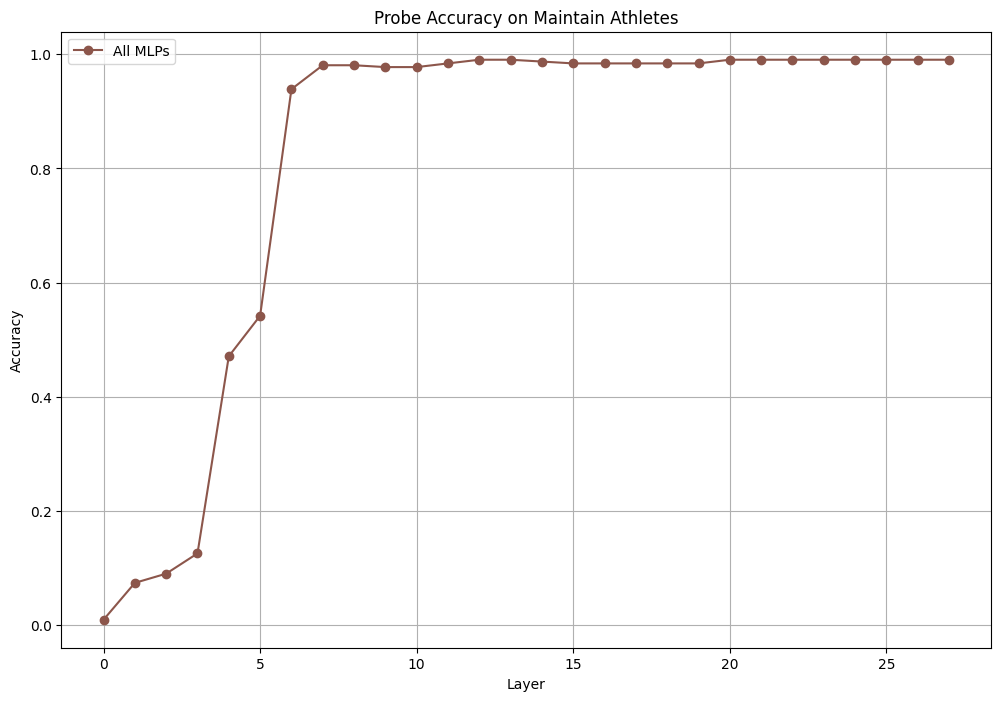

In [ ]:
import matplotlib.pyplot as plt

def plot_final_accuracies(all_accs, formal=True):
    # colors = plt.cm.get_cmap('tab10', len(all_train_accs))  # Get a colormap with enough colors for all models

    plt.figure(figsize=(12, 8))
    
    for idx, model_name in enumerate(all_train_accs.keys()):
        layers = list(all_train_accs[model_name].keys())
        accs = [all_accs[model_name][layer] for layer in layers]

        # plt.plot(layers, train_accs, label=f'{model_name} Train', color=colors(idx), linestyle=line_styles[0], alpha=0.5)
        # plt.plot(layers, forget_accs, label=f'{model_name} Forget', color=colors[idx], linestyle=line_styles[1])
        plt.plot(layers, accs, label=f'{formal_name_dict[model_name]}', color=color_map[model_name], marker='o')
    
    plt.xlabel('Layer')
    plt.ylabel('Accuracy')

# Call the function to plot the accuracies
plot_final_accuracies(all_maintain_accs)
plt.title('Probe Accuracy on Maintain Athletes')
plt.legend()
plt.grid(True)
plt.show()


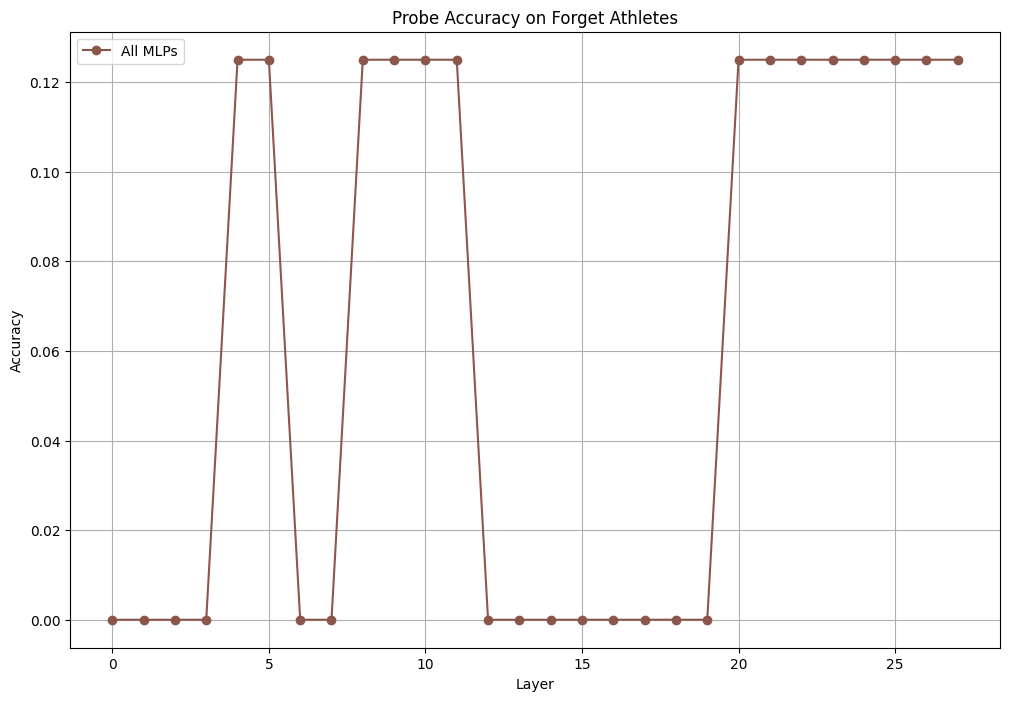

In [ ]:
plot_final_accuracies(all_forget_accs)
plt.title('Probe Accuracy on Forget Athletes')
plt.legend()
plt.grid(True)
plt.show()